In [2]:
#Import libraries and introduce updated network class 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import random

class Network(object):
    
    def __init__(self, num_nodes):
        self.adj = {i: set() for i in range(num_nodes)}
        
    def add_edge(self, i, j):
        self.adj[i].add(j)
        self.adj[j].add(i)
    
    # Added for task 2.7 
    def degree_sequence(self):
        return [len(neighbors) for neighbors in self.adj.values()]
    
    def neighbours(self, i):
        return self.adj[i]
    
    def edge_list(self):
        return [(i, j) for i in self.adj for j in self.adj[i] if i < j]
    
    #Added for task 4.4 
    def remove_node(self, node):
        # Make a copy of the set of neighbors
        neighbours = self.adj[node].copy()
    
        # Remove all edges connected to the node
        for neighbour in neighbours:
            self.adj[neighbour].remove(node)
    
        # Remove the node from the adjacency list
        del self.adj[node]
    
    def remove_edge(self, i, j):
        if j in self.adj[i]:
            self.adj[i].remove(j)
        if i in self.adj[j]:
            self.adj[j].remove(i)

In [205]:
# Implementation of the configuration model

def configuration_model(k):
    """
    Create a network using the configuration model.
    
    Parameters:
    - k: list of degree distribution
    
    Returns:
    - network: with the degree distribution k 
    """
    n = len(k)
   
    # Create network object
    network = Network(n)
    
    # Create the list S based on the degree sequence
    S = np.array([i for i in range(n) for _ in range(k[i])])
    
    # Shuffle the list S
    S = np.random.permutation(S)
    
    # If the length of S is odd, drop the last element
    if len(S) % 2:
        S = S[:-1]
    
    # Reshape S into pairs of nodes
    S = S.reshape(-1, 2)
    
    # Add edges to the network
    for pair in S:
        i, j = pair
        network.add_edge(i, j)
    
    return network


In [3]:
def barabasi_albert_model(num_nodes, m):
    """
    Create a scale-free network using the Barabási-Albert model.
    
    Parameters:
    - num_nodes: Number of nodes in the network
    - m: Number of edges to attach from a new node to existing nodes
    
    Returns:
    - network: An instance of the Network class representing the scale-free network
    """
    network = Network(num_nodes)
    
    # Start with a small fully connected network
    for i in range(m):
        for j in range(i + 1, m):
            network.add_edge(i, j)
    
    # Add new nodes with preferential attachment
    node_degrees = [m] * m  # Initialise degrees of the first m nodes
    for new_node in range(m, num_nodes):
        targets = set()
        while len(targets) < m:
            r = random.choices(range(new_node), weights=node_degrees, k=1)[0]
            targets.add(r)
        for target in targets:
            network.add_edge(new_node, target)
            node_degrees[target] += 1
        node_degrees.append(m)
    
    return network

In [207]:
#Sample from Poisson and geometric distributions 

def poisson_sample(num_nodes, mean_degree):
   
    # Generate a degree sequence using Poisson distribution
    degree_sequence = np.random.poisson(mean_degree, num_nodes)
    
    return degree_sequence

def geometric_sample(num_nodes, mean_degree):
    
    #Sample following a geometric distribution
    
    p = 1 / (mean_degree + 1)  # Adjust p to get the desired mean degree
    
    return np.random.geometric(p, num_nodes) - 1

In [208]:
# Simulates SIR process and returns the final state of every node
def simulate_SIR_fast(network, lambda_value, max_iterations=100):
    num_nodes = len(network.adj)
    # Initialise all nodes as susceptible
    state = ['S'] * num_nodes
    
    #set the size of the outbreak
    num_infected = 100
     # Choose a small fraction of nodes to be initially infected
    initial_infected = np.random.choice(num_nodes, num_infected, replace=False)
    for node in initial_infected:
        state[node] = 'I'
    
    while 'I' in state and max_iterations > 0:  #simulate until extinction
        new_infected = set()
        for node in range(num_nodes):
            if state[node] == 'I':
                for neighbour in network.neighbours(node):
                    if state[neighbour] == 'S' and np.random.rand() < lambda_value:
                        new_infected.add(neighbour)
                state[node] = 'R'
                
        for node in new_infected:
            state[node] = 'I'
        max_iterations -= 1

    return state

In [209]:
#Function to simulate vaccination by choosing random nodes and removing them from the network 
def random_vaccination(network, fraction):
    # Calculate the number of nodes to remove
    num_nodes_to_vaccinate = int(fraction * len(network.adj))
    
    # Get the list of all nodes
    all_nodes = list(network.adj.keys())
    
    # Select nodes randomly
    nodes_to_vaccinate = np.random.choice(all_nodes, num_nodes_to_vaccinate, replace=False)
    
    # Remove each selected node and its edges
    for node in nodes_to_vaccinate:
        network.remove_node(node)
        
    # Reindex the nodes
    new_adj = {}
    new_index = 0
    reindex_map = {}
    for old_index in network.adj.keys():
        if old_index not in nodes_to_vaccinate:
            reindex_map[old_index] = new_index
            new_adj[new_index] = set()
            new_index += 1
    
    # Update the adjacency list with reindexed nodes
    for old_index, neighbours in network.adj.items():
        if old_index not in nodes_to_vaccinate:
            new_neighbours = [reindex_map[n] for n in neighbours if n not in nodes_to_vaccinate]
            new_adj[reindex_map[old_index]] = set(new_neighbours)
    
    network.adj = new_adj
    
    return network

In [210]:
# Use to be able to vaccinate at different rates 
def copy_network(network):
    # Create a new Network object with the same number of nodes
    new_network = Network(len(network.adj))
    
    # Copy the adjacency list
    for node, neighbors in network.adj.items():
        for neighbor in neighbors:
            new_network.add_edge(node, neighbor)
    
    return new_network

In [239]:
def simulate_outbreak(network, lambda_values):
    outbreak_sizes = []
    for lambda_value in lambda_values:
        final_state = simulate_SIR_fast(network, lambda_value)
        outbreak_size = final_state.count('R') + final_state.count('I')
        outbreak_sizes.append(outbreak_size)
    return outbreak_sizes

def plot_outbreak_sizes(lambda_values, outbreak_sizes, vaccination_rate, protocol, distribution):
    plt.plot(lambda_values, outbreak_sizes, marker='o', markersize=3, label=f'{protocol}, v.rate = {vaccination_rate}')
    plt.xlabel('Lambda (λ)', fontsize = 14)
    plt.ylabel('Outbreak Size', fontsize = 14)
    plt.title(f'Outbreak Size vs Lambda (λ) [{distribution} Distribution]', fontsize = 16)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True)

def plot_outbreak_sizes_multiple_nominations(lambda_values, outbreak_sizes, vaccination_rate, protocol, num_nominations, distribution):
    plt.plot(lambda_values, outbreak_sizes, marker='o', markersize=3, label=f'{protocol}, v.rate = {vaccination_rate}, nominations = {num_nominations}')
    plt.xlabel('Lambda (λ)', fontsize = 14)
    plt.ylabel('Outbreak Size', fontsize = 14)
    plt.title(f'Outbreak Size vs Lambda (λ) [{distribution} Distribution]', fontsize = 16)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True)

In [212]:
# Targeted vaccination method 

def targeted_vaccination(network, fraction):
    # Calculate the number of nodes to remove
    num_nodes_to_vaccinate = int(fraction * len(network.adj))
    
    # Calculate the degree of each node
    degrees = {node: len(neighbours) for node, neighbours in network.adj.items()}
    
    # Sort nodes by degree in descending order
    nodes_sorted_by_degree = sorted(degrees, key=degrees.get, reverse=True)
    
    # Select the top nodes based on their degree
    nodes_to_vaccinate = nodes_sorted_by_degree[:num_nodes_to_vaccinate]
    
    # Remove each selected node and its edges
    for node in nodes_to_vaccinate:
        network.remove_node(node)
    
    # Reindex the nodes
    new_adj = {}
    new_index = 0
    reindex_map = {}
    for old_index in network.adj.keys():
        reindex_map[old_index] = new_index
        new_adj[new_index] = set()
        new_index += 1
    
    # Update the adjacency list with reindexed nodes
    for old_index, neighbours in network.adj.items():
        new_neighbours = {reindex_map[n] for n in neighbours}
        new_adj[reindex_map[old_index]] = new_neighbours
    
    network.adj = new_adj
    
    return network

In [213]:
# Targeted vaccination method for vulnerable nodes (least degrees)

def targeted_vaccination_vulnerable(network, fraction):
    # Calculate the number of nodes to remove
    num_nodes_to_vaccinate = int(fraction * len(network.adj))
    
    # Calculate the degree of each node
    degrees = {node: len(neighbours) for node, neighbours in network.adj.items()}
    
    # Sort nodes by degree in ascending order
    nodes_sorted_by_degree = sorted(degrees, key=degrees.get, reverse=False)
    
    # Select the top nodes based on their degree
    nodes_to_vaccinate = nodes_sorted_by_degree[:num_nodes_to_vaccinate]
    
    # Remove each selected node and its edges
    for node in nodes_to_vaccinate:
        network.remove_node(node)
    
    # Reindex the nodes
    new_adj = {}
    new_index = 0
    reindex_map = {}
    for old_index in network.adj.keys():
        reindex_map[old_index] = new_index
        new_adj[new_index] = set()
        new_index += 1
    
    # Update the adjacency list with reindexed nodes
    for old_index, neighbours in network.adj.items():
        new_neighbours = {reindex_map[n] for n in neighbours}
        new_adj[reindex_map[old_index]] = new_neighbours
    
    network.adj = new_adj
    
    return network

In [214]:
# Test the multiple nomination method 

def multiple_nomination_vaccination(network, fraction, num_nominations):
    # Calculate the number of nodes to remove
    num_nodes_to_vaccinate = int(fraction * len(network.adj))
    
    # Initialise nomination counts
    nomination_counts = {node: 0 for node in network.adj.keys()}
    
     # Keep vaccinating until the desired number of nodes is vaccinated
    vaccinated_nodes = set()
    
    while len(vaccinated_nodes) < num_nodes_to_vaccinate:
        # Get the list of all nodes
        all_nodes = list(network.adj.keys())
        
        # Select a different batch of nodes randomly for every iteration
        nominated_nodes = np.random.choice(all_nodes, num_nodes_to_vaccinate - len(vaccinated_nodes), replace=False)
        
        # Nominate friends
        for node in nominated_nodes:
            if network.adj[node]:  # Ensure the node has neighbors
                friend = np.random.choice(list(network.adj[node]))
                nomination_counts[friend] += 1
                if nomination_counts[friend] >= num_nominations and friend not in vaccinated_nodes:
                    vaccinated_nodes.add(friend)
                    if len(vaccinated_nodes) >= num_nodes_to_vaccinate:
                        break
    
                    
    # Remove each selected node and its edges
    for node in vaccinated_nodes:
        network.remove_node(node)
        
    # Reindex the nodes
    new_adj = {}
    new_index = 0
    reindex_map = {}
    for old_index in network.adj.keys():
        if old_index not in vaccinated_nodes:
            reindex_map[old_index] = new_index
            new_adj[new_index] = set()
            new_index += 1
    
    # Update the adjacency list with reindexed nodes
    for old_index, neighbours in network.adj.items():
        if old_index not in vaccinated_nodes:
            new_neighbours = [reindex_map[n] for n in neighbours if n not in vaccinated_nodes]
            new_adj[reindex_map[old_index]] = set(new_neighbours)
    
    network.adj = new_adj
    
    return network

In [215]:
# How to run simulations

# Parameters
num_nodes = 10000
mean_degree = 20
lambda_values = np.linspace(0, 1.0, 51)
vaccination_rates = [0.8, 0.6, 0.4, 0.2, 0]
num_nominations = 5
m = 10

#Create the poisson and geometric samples 
poisson_degrees = poisson_sample(num_nodes, mean_degree)
geometric_degrees = geometric_sample(num_nodes, mean_degree)

# Generate the network for poisson and geometric sample
network_poisson = configuration_model(poisson_degrees)
network_geometric = configuration_model(geometric_degrees)
network_scale_free = barabasi_albert_model(num_nodes, m)



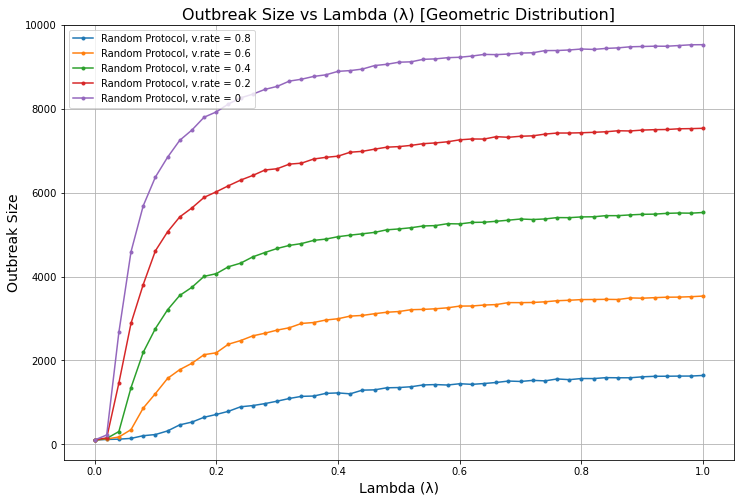

In [237]:
# Simulations for random vaccination method

distribution = 'Geometric'
plt.figure(figsize=(12, 8))
for rate in vaccination_rates:
    if rate > 0:
        network_after_vaccination = random_vaccination(copy_network(network_geometric), rate)
    else:
        network_after_vaccination = network_geometric
    outbreak_sizes = simulate_outbreak(network_after_vaccination, lambda_values)
    plot_outbreak_sizes(lambda_values, outbreak_sizes, rate, 'Random Protocol', distribution)

#plt.legend()
plt.show()

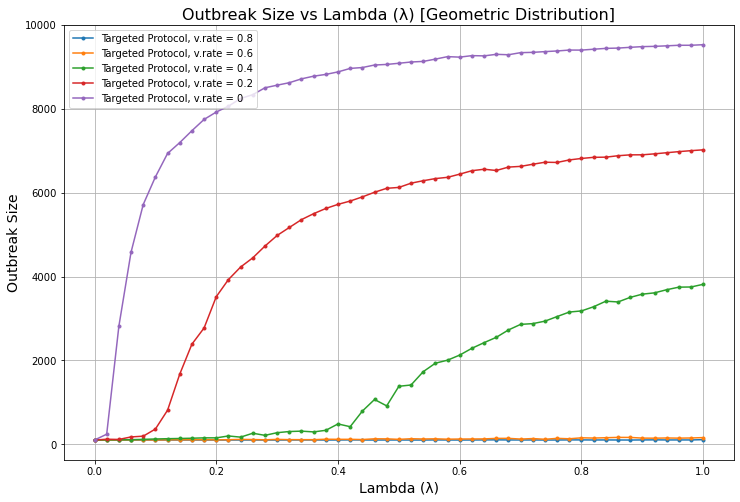

In [238]:
# Simulations for targeted vaccination method

distribution = 'Geometric'
plt.figure(figsize=(12, 8))
for rate in vaccination_rates:
    if rate > 0:
        network_after_vaccination = targeted_vaccination(copy_network(network_geometric), rate)
    else:
        network_after_vaccination = network_geometric
    outbreak_sizes = simulate_outbreak(network_after_vaccination, lambda_values)
    plot_outbreak_sizes(lambda_values, outbreak_sizes, rate, 'Targeted Protocol', distribution)

#plt.legend()
plt.show()

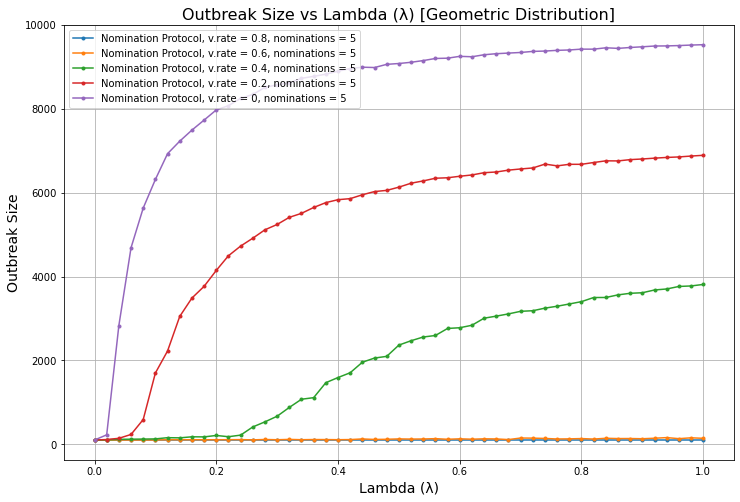

In [240]:
# Simulations for multiple nominations method

num_nominations = 5

plt.figure(figsize=(12, 8))
for rate in vaccination_rates:
    if rate > 0:
        network_after_vaccination = multiple_nomination_vaccination(copy_network(network_geometric), rate, num_nominations)
    else:
        network_after_vaccination = network_geometric
    outbreak_sizes = simulate_outbreak(network_after_vaccination, lambda_values)
    plot_outbreak_sizes_multiple_nominations(lambda_values, outbreak_sizes, rate, 'Nomination Protocol', num_nominations, distribution)

#plt.legend()
plt.show()

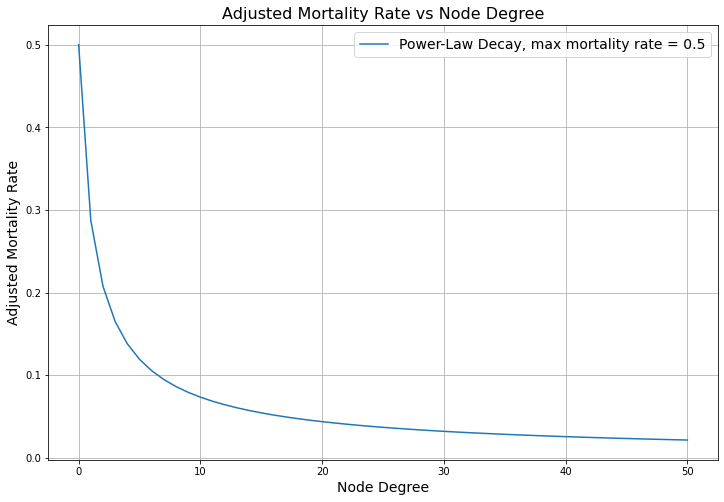

In [244]:
# Evaluate what the best mathematical model is for the death probabilities

import numpy as np
import matplotlib.pyplot as plt

# Define the different adjusted mortality rate functions

def adjusted_mortality_rate_linear(mortality_rate, node_degree):
    return mortality_rate / (node_degree + 1)

def adjusted_mortality_rate_exponential(mortality_rate, node_degree, k=0.1):
    return mortality_rate * np.exp(-k * node_degree)

def adjusted_mortality_rate_power_law(mortality_rate, node_degree, alpha=0.8):
    return mortality_rate / (node_degree + 1)**0.8

def adjusted_mortality_rate_sigmoid(mortality_rate, node_degree, k=0.1, d=5):
    return mortality_rate / (1 + np.exp(k * (node_degree - d)))

def adjusted_mortality_rate_piecewise(mortality_rate, node_degree, d1=5, d2=10):
    if node_degree < d1:
        return mortality_rate
    elif node_degree < d2:
        return mortality_rate / 2
    else:
        return mortality_rate / 4

def adjusted_mortality_rate_log_shifted(mortality_rate, node_degree):
    return mortality_rate / np.log(node_degree + 2)

# Set parameters
mortality_rate = 0.5
degrees = np.arange(0, 51)

# Calculate mortality rates for each degree using different functions
linear_rates = [adjusted_mortality_rate_linear(mortality_rate, d) for d in degrees]
exponential_rates = [adjusted_mortality_rate_exponential(mortality_rate, d) for d in degrees]
power_law_rates = [adjusted_mortality_rate_power_law(mortality_rate, d) for d in degrees]
sigmoid_rates = [adjusted_mortality_rate_sigmoid(mortality_rate, d) for d in degrees]
piecewise_rates = [adjusted_mortality_rate_piecewise(mortality_rate, d) for d in degrees]
log_shifted_rates = [adjusted_mortality_rate_log_shifted(mortality_rate, d) for d in degrees]

# Plot the results
plt.figure(figsize=(12, 8))

#plt.plot(degrees, linear_rates, label='Linear Inverse Proportionality')
#plt.plot(degrees, exponential_rates, label='Exponential Decay')
plt.plot(degrees, power_law_rates,  label=f'Power-Law Decay, max mortality rate = {mortality_rate}')
#plt.plot(degrees, sigmoid_rates, label='Sigmoid Function')
#plt.plot(degrees, piecewise_rates, label='Piecewise Function')
#plt.plot(degrees, log_shifted_rates, label='Logarithmic Inverse Proportionality with Shift')

plt.xlabel('Node Degree', fontsize = 14)
plt.ylabel('Adjusted Mortality Rate', fontsize = 14)
plt.title('Adjusted Mortality Rate vs Node Degree', fontsize = 16)

plt.legend(loc='upper right', fontsize=14)  # Adjust the fontsize here
plt.grid(True)
plt.show()

In [6]:
# Combine vaccination in real time with death model for random vaccination

def simulate_SIR_random_vaccination_mortality(network, lambda_value, vaccination_rate, mortality_rate, max_iterations=100):
    num_nodes = len(network.adj)
    state = ['S'] * num_nodes
    
    num_infected = 100
    initial_infected = np.random.choice(num_nodes, num_infected, replace=False)
    for node in initial_infected:
        state[node] = 'I'
    
    while 'I' in state and max_iterations > 0:
        new_infected = set()
        
      # Vaccination
        target_vaccinations = int(vaccination_rate * num_nodes)
        vaccinated_count = 0
        max_vaccination_attempts = 2 * target_vaccinations

        while vaccinated_count < target_vaccinations and max_vaccination_attempts > 0 and 'S' in state:
            node = np.random.choice(num_nodes)
            if state[node] == 'S':
                state[node] = 'V'
                vaccinated_count += 1
            max_vaccination_attempts -= 1

        # Check if there are no susceptible nodes left
        if 'S' not in state:
            break
        
        for node in range(num_nodes):
            if state[node] == 'I':
                for neighbour in network.neighbours(node):
                    if state[neighbour] == 'S' and np.random.rand() < lambda_value:
                        new_infected.add(neighbour)
                
                node_degree = len(network.neighbours(node))
                adjusted_mortality_rate = mortality_rate / (node_degree + 1)**0.8
                if np.random.rand() < adjusted_mortality_rate:
                    state[node] = 'D'
                else:
                    state[node] = 'R'
                
        for node in new_infected:
            state[node] = 'I'
        
        max_iterations -= 1

    num_recovered = state.count('R')
    num_dead = state.count('D')
    total_infected = state.count('R') + state.count('D') + state.count('I')
    return num_recovered, num_dead, total_infected

In [7]:
# Combine vaccination in real time with death model for targeted vaccination

def simulate_SIR_targeted_high_vaccination_mortality(network, lambda_value, vaccination_rate, mortality_rate, max_iterations=100):
    num_nodes = len(network.adj)
    state = ['S'] * num_nodes
    
    num_infected = 100
    initial_infected = np.random.choice(num_nodes, num_infected, replace=False)
    for node in initial_infected:
        state[node] = 'I'
    
    while 'I' in state and max_iterations > 0:
        new_infected = set()
        
        degrees = {node: len(neighbours) for node, neighbours in network.adj.items()}
        nodes_sorted_by_degree = sorted(degrees, key=degrees.get, reverse=True)
        
         # Vaccination
        target_vaccinations = int(vaccination_rate * num_nodes)
        vaccinated_count = 0
        
        # Filter out already vaccinated nodes from the list of degrees
        nodes_sorted_by_degree = [node for node in nodes_sorted_by_degree if state[node] == 'S']
        
        for node in nodes_sorted_by_degree:
            state[node] = 'V'
            vaccinated_count += 1
            if vaccinated_count >= target_vaccinations:
                break
        
        
        for node in range(num_nodes):
            if state[node] == 'I':
                for neighbour in network.neighbours(node):
                    if state[neighbour] == 'S' and np.random.rand() < lambda_value:
                        new_infected.add(neighbour)
                
                node_degree = len(network.neighbours(node))
                adjusted_mortality_rate = mortality_rate / (node_degree + 1)**0.8
                if np.random.rand() < adjusted_mortality_rate:
                    state[node] = 'D'
                else:
                    state[node] = 'R'
                
        for node in new_infected:
            state[node] = 'I'
        
        max_iterations -= 1

    num_recovered = state.count('R')
    num_dead = state.count('D')
    total_infected = state.count('R') + state.count('D') + state.count('I')
    return num_recovered, num_dead, total_infected


In [8]:
# Combine vaccination in real time with death model for targeted vulnerable vaccination

def simulate_SIR_targeted_low_vaccination_mortality(network, lambda_value, vaccination_rate, mortality_rate, max_iterations=100):
    num_nodes = len(network.adj)
    state = ['S'] * num_nodes
    
    num_infected = 100
    initial_infected = np.random.choice(num_nodes, num_infected, replace=False)
    for node in initial_infected:
        state[node] = 'I'
    
    while 'I' in state and max_iterations > 0:
        new_infected = set()
        
        degrees = {node: len(neighbours) for node, neighbours in network.adj.items()}
        nodes_sorted_by_degree = sorted(degrees, key=degrees.get)
        
         # Vaccination
        target_vaccinations = int(vaccination_rate * num_nodes)
        vaccinated_count = 0
        
        # Filter out already vaccinated nodes from the list of degrees
        nodes_sorted_by_degree = [node for node in nodes_sorted_by_degree if state[node] == 'S']
        
        for node in nodes_sorted_by_degree:
            state[node] = 'V'
            vaccinated_count += 1
            if vaccinated_count >= target_vaccinations:
                break
        
        for node in range(num_nodes):
            if state[node] == 'I':
                for neighbour in network.neighbours(node):
                    if state[neighbour] == 'S' and np.random.rand() < lambda_value:
                        new_infected.add(neighbour)
                
                node_degree = len(network.neighbours(node))
                adjusted_mortality_rate = mortality_rate / (node_degree + 1)**0.8
                if np.random.rand() < adjusted_mortality_rate:
                    state[node] = 'D'
                else:
                    state[node] = 'R'
                
        for node in new_infected:
            state[node] = 'I'
        
        max_iterations -= 1

    num_recovered = state.count('R')
    num_dead = state.count('D')
    total_infected = state.count('R') + state.count('D') + state.count('I')
    return num_recovered, num_dead, total_infected

In [9]:
# Combine vaccination in real time with death model for multiple nominations vaccination

def simulate_SIR_nomination_vaccination_mortality(network, lambda_value, vaccination_rate, mortality_rate, num_nominations, max_iterations=100):
    num_nodes = len(network.adj)
    state = ['S'] * num_nodes
    
    num_infected = 100
    initial_infected = np.random.choice(num_nodes, num_infected, replace=False)
    for node in initial_infected:
        state[node] = 'I'
    
    while 'I' in state and max_iterations > 0:
        new_infected = set()
    
        # Vaccination
        target_vaccinations = int(vaccination_rate * num_nodes)
        nomination_counts = {node: 0 for node in network.adj.keys()}
        vaccinated_nodes = set()
        max_vaccination_attempts = 2 * num_nominations * target_vaccinations
    
        while len(vaccinated_nodes) < target_vaccinations and max_vaccination_attempts > 0:
            node = np.random.choice(num_nodes)
            if (state[node] == 'S' or state[node] == 'R') and network.adj[node]:
                eligible_neighbors = [neighbor for neighbor in network.adj[node] if state[neighbor] == 'S' and neighbor not in vaccinated_nodes]
                if eligible_neighbors:
                    friend = np.random.choice(eligible_neighbors)
                    nomination_counts[friend] += 1
                    state[friend] = 'V'
                    vaccinated_nodes.add(friend)
            max_vaccination_attempts -= 1
    
        # Check if there are no susceptible nodes left
        if 'S' not in state:
            break
        
        for node in range(num_nodes):
            if state[node] == 'I':
                for neighbour in network.neighbours(node):
                    if state[neighbour] == 'S' and np.random.rand() < lambda_value:
                        new_infected.add(neighbour)
                
                node_degree = len(network.neighbours(node))
                adjusted_mortality_rate = mortality_rate / (node_degree + 1)**0.8
                if np.random.rand() < adjusted_mortality_rate:
                    state[node] = 'D'
                else:
                    state[node] = 'R'
                
        for node in new_infected:
            state[node] = 'I'
        
        max_iterations -= 1

    num_recovered = state.count('R')
    num_dead = state.count('D')
    total_infected = state.count('R') + state.count('D') + state.count('I')
    return num_recovered, num_dead, total_infected


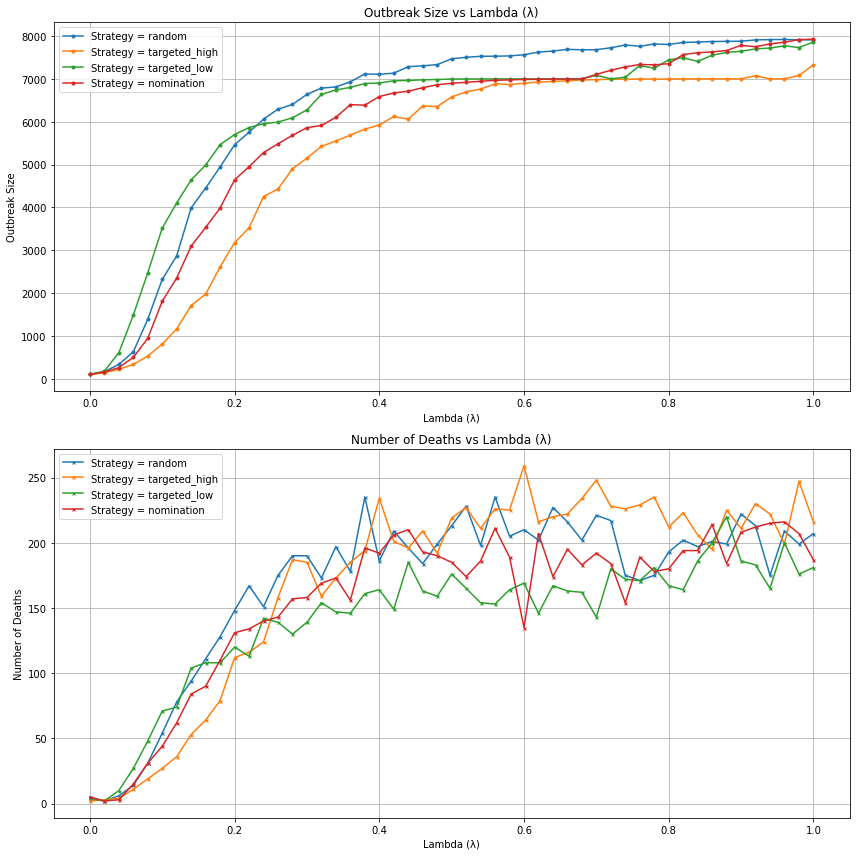

In [130]:
# Simulate VSIRD process 

def simulate_outbreak_vaccination_mortality(network, lambda_values, vaccination_rate, mortality_rate, vaccination_strategy, *args):
    dead_sizes = []
    outbreak_sizes = []
    for lambda_value in lambda_values:
        if vaccination_strategy == 'random':
            _, num_dead, total_infected = simulate_SIR_random_vaccination_mortality(network, lambda_value, vaccination_rate, mortality_rate)
        elif vaccination_strategy == 'targeted_high':
            _, num_dead, total_infected = simulate_SIR_targeted_high_vaccination_mortality(network, lambda_value, vaccination_rate, mortality_rate)
        elif vaccination_strategy == 'targeted_low':
            _, num_dead, total_infected = simulate_SIR_targeted_low_vaccination_mortality(network, lambda_value, vaccination_rate, mortality_rate)
        elif vaccination_strategy == 'nomination':
            _, num_dead, total_infected = simulate_SIR_nomination_vaccination_mortality(network, lambda_value, vaccination_rate, mortality_rate, *args)
        
        dead_sizes.append(num_dead)
        outbreak_sizes.append(total_infected)
    return dead_sizes, outbreak_sizes

# Parameters
num_nodes = 10000
m = 10
lambda_values = np.linspace(0, 1.0, 51)
mortality_rate = 0.5  
vaccination_rate = 0.1
num_nominations = 5

# Generate the scale-free network
#network_scale_free = barabasi_albert_model(num_nodes, m)

# Strategies
strategies = [ 'random', 'targeted_high', 'targeted_low', 'nomination']

plt.figure(figsize=(12, 12))
for strategy in strategies:
    if strategy == 'nomination':
        dead_sizes, outbreak_sizes = simulate_outbreak_vaccination_mortality(network_scale_free, lambda_values, vaccination_rate, mortality_rate, strategy, num_nominations)
    else:
        dead_sizes, outbreak_sizes = simulate_outbreak_vaccination_mortality(network_scale_free, lambda_values, vaccination_rate, mortality_rate, strategy)
    
    plt.subplot(2, 1, 1)
    plt.plot(lambda_values, outbreak_sizes, marker='o', markersize=3, label=f'Strategy = {strategy}')
    
    plt.subplot(2, 1, 2)
    plt.plot(lambda_values, dead_sizes, marker='x', markersize=3, label=f'Strategy = {strategy}')

plt.subplot(2, 1, 1)
plt.xlabel('Lambda (λ)')
plt.ylabel('Outbreak Size')
plt.title('Outbreak Size vs Lambda (λ) [Scale-Free Distribution]')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.xlabel('Lambda (λ)')
plt.ylabel('Number of Deaths')
plt.title('Number of Deaths vs Lambda (λ) [Scale-Free Distribution]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


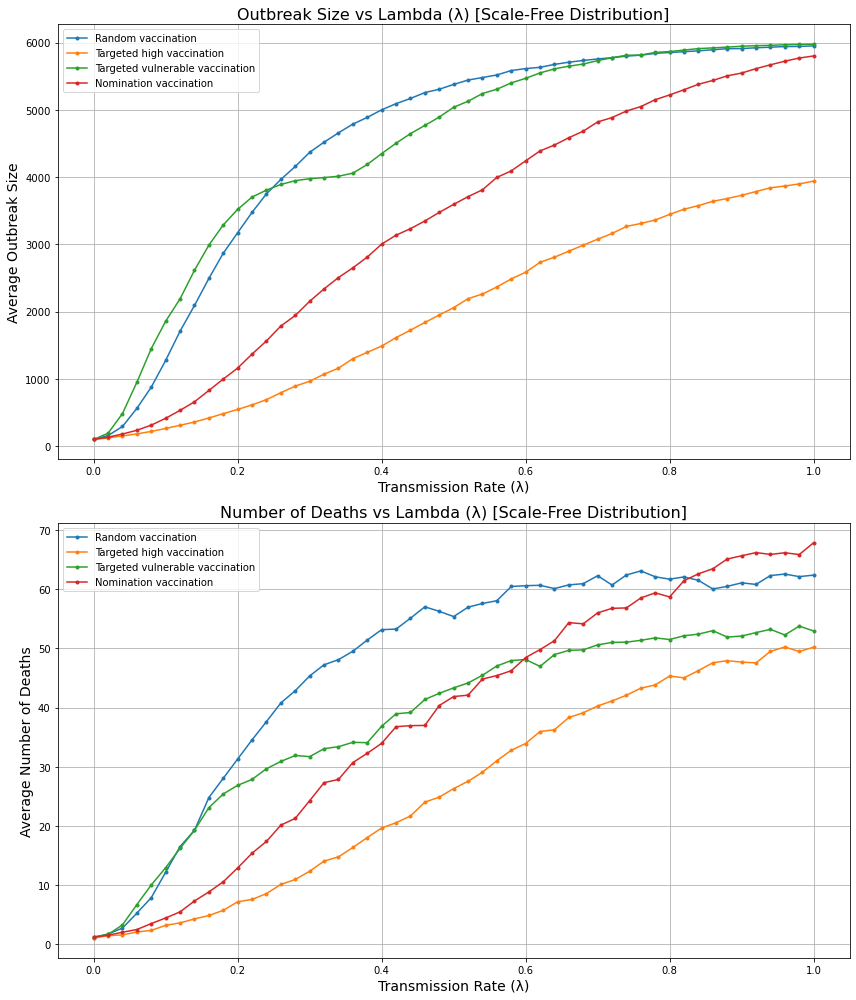

In [195]:
#Smoothed results averaging multiple simulations

# Function to simulate outbreaks and deaths
def simulate_outbreak_and_deaths_avg(network, lambda_values, vaccination_rate, mortality_rate, vaccination_strategy, num_simulations, num_nominations=None):
    avg_outbreak_sizes = []
    avg_dead_sizes = []

    for lambda_value in lambda_values:
        outbreak_sizes_simulations = []
        dead_sizes_simulations = []
        for _ in range(num_simulations):
            if vaccination_strategy == 'Random':
                _, num_dead, total_infected = simulate_SIR_random_vaccination_mortality(network, lambda_value, vaccination_rate, mortality_rate)
            elif vaccination_strategy == 'Targeted high':
                _, num_dead, total_infected = simulate_SIR_targeted_high_vaccination_mortality(network, lambda_value, vaccination_rate, mortality_rate)
            elif vaccination_strategy == 'Targeted vulnerable':
                _, num_dead, total_infected = simulate_SIR_targeted_low_vaccination_mortality(network, lambda_value, vaccination_rate, mortality_rate)
            elif vaccination_strategy == 'Nomination':
                _, num_dead, total_infected = simulate_SIR_nomination_vaccination_mortality(network, lambda_value, vaccination_rate, mortality_rate, num_nominations)
            
            outbreak_sizes_simulations.append(total_infected)
            dead_sizes_simulations.append(num_dead)

        avg_outbreak_sizes.append(np.mean(outbreak_sizes_simulations))
        avg_dead_sizes.append(np.mean(dead_sizes_simulations))
    
    return avg_outbreak_sizes, avg_dead_sizes

# Plotting function
def plot_outbreak_and_deaths(network, lambda_values, vaccination_rate, mortality_rate, vaccination_strategy, num_simulations, num_nominations=None):
    strategies = ['Random', 'Targeted high', 'Targeted vulnerable', 'Nomination']
    
    plt.figure(figsize=(12, 14))
    
    for strategy in strategies:
        if strategy == 'Nomination':
            avg_outbreak_sizes, avg_dead_sizes = simulate_outbreak_and_deaths_avg(network, lambda_values, vaccination_rate, mortality_rate, strategy, num_simulations, num_nominations)
        else:
            avg_outbreak_sizes, avg_dead_sizes = simulate_outbreak_and_deaths_avg(network, lambda_values, vaccination_rate, mortality_rate, strategy, num_simulations)
        
        plt.subplot(2, 1, 1)
        plt.plot(lambda_values, avg_outbreak_sizes, marker='o', markersize=3, label=f'{strategy} vaccination')
        plt.ylabel('Average Outbreak Size', fontsize = 14)
        plt.xlabel('Transmission Rate (λ)', fontsize = 14)
        plt.title('Outbreak Size vs Lambda (λ) [Scale-Free Distribution]', fontsize = 16)
        plt.grid(True)
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(lambda_values, avg_dead_sizes, marker='o', markersize=3, label=f'{strategy} vaccination')
        plt.ylabel('Average Number of Deaths', fontsize = 14)
        plt.xlabel('Transmission Rate (λ)', fontsize = 14)
        plt.title('Number of Deaths vs Lambda (λ) [Scale-Free Distribution]', fontsize = 16)
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()


# Parameters
num_nodes = 10000
m = 10
lambda_values = np.linspace(0, 1.0, 51)
mortality_rate = 0.1  
vaccination_rate = 0.2
num_nominations = 5
num_simulations = 100

# Generate the scale-free network
#network_scale_free = barabasi_albert_model(num_nodes, m)

plot_outbreak_and_deaths(network_scale_free, lambda_values, vaccination_rate, mortality_rate, 'random', num_simulations, num_nominations)